In [2]:
import numpy as np
import h5py
from aiproteomics.comparison.ComparisonPrositFrag import ComparisonPrositFrag
from dask import array as da
import matplotlib.pyplot as plt
import seaborn as sns
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
import pandas as pd
%matplotlib inline

In [3]:
# Turns out it was better to store the results in a hdf5 file
# predictions = np.load("predictions.npy")

# with h5py.File("predictions.hdf5", "w") as f:
#     dset = f.create_dataset("predictions", predictions.shape, predictions.dtype)
#     dset[:, :] = predictions

In [4]:
def load_dask_array_from_hdf5(filename, key, chunksize=1000):
    f = h5py.File(filename)
    return da.from_array(f[key], chunks=chunksize)

In [6]:
predictions = load_dask_array_from_hdf5("predictions.hdf5", "predictions")
labels = load_dask_array_from_hdf5("traintest_hcd.hdf5", "intensities_raw")
collision_energy = load_dask_array_from_hdf5("traintest_hcd.hdf5", "collision_energy")
precursor_charge = load_dask_array_from_hdf5("traintest_hcd.hdf5", "precursor_charge_onehot")
sequences = load_dask_array_from_hdf5("traintest_hcd.hdf5", "sequence_integer")

In [7]:
full_sequences = sequences[:,-1] > 0

full_sequences.shape

(6787933,)

In [8]:
sequence_lengths= da.argmin(sequences, axis=1)

In [9]:
sequence_lengths[full_sequences] = 29

In [10]:
f = h5py.File("traintest_hcd.hdf5")

f.keys()

<KeysViewHDF5 ['collision_energy', 'collision_energy_aligned', 'collision_energy_aligned_normed', 'intensities_raw', 'masses_pred', 'masses_raw', 'method', 'precursor_charge_onehot', 'rawfile', 'reverse', 'scan_number', 'score', 'sequence_integer', 'sequence_onehot']>

In [11]:
["collision_energy_aligned_normed", "precursor_charge_onehot", "sequence_integer"]

['collision_energy_aligned_normed',
 'precursor_charge_onehot',
 'sequence_integer']

In [12]:
labels.shape

(6787933, 174)

In [13]:
predictions.shape

(6787933, 174)

In [14]:
labels[0].compute()

array([ 0.03333019,  0.        ,  0.        ,  0.00833965,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.39771285,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.12638215,  0.        ,  0.        ,  0.00881359,  0.        ,
        0.        ,  0.0085394 ,  0.        ,  0.        ,  0.02134586,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.01633287,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.01483933,  0.        ,  0.02334369,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.00457667,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.00765157,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.02404616,  0.        ,  0.  

/home/godsnor/miniconda3/envs/ppt/lib/python3.10/site-packages/dask/dataframe/core.py:8393: UserWarning: Insufficient elements for `head`. 1000 elements requested, only 668 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


In [18]:
from sklearn.preprocessing import normalize


# TODO: Check if results are the same as with ComparisonPrositFrag
def normalized_spectral_contrast_distance(true, pred):
    """
    Calculate the (normalized) spectral contrast distance for two spectra. 1 represents total overlap.
    """
    pred_norm = normalize(pred)
    true_norm = normalize(true)
    
    product =  pred_norm * true_norm
    product = product.sum(axis=1)
    
    arccos = np.arccos(product)
    return 1 - 2 * arccos / np.pi



In [19]:
normalized_spectral_contrast_distance(labels[:2], predictions[:2])

/home/godsnor/miniconda3/envs/ppt/lib/python3.10/site-packages/dask/array/core.py:1705: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/godsnor/miniconda3/envs/ppt/lib/python3.10/site-packages/dask/array/core.py:1705: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


array([ 0.06520899, -0.05064844])

In [20]:
limit=None

comparisons = da.map_blocks(normalized_spectral_contrast_distance, labels[:limit], predictions[:limit], drop_axis=1, dtype=float)

comparisons

dask.array<normalized_spectral_contrast_distance, shape=(6787933,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

In [21]:
computation, edges = da.histogram(comparisons, bins=50, range=(0, 1))

with ProgressBar():
    hist = computation.compute()


[########################################] | 100% Completed | 18m 18s


/home/godsnor/miniconda3/envs/ppt/lib/python3.10/site-packages/dask/dataframe/core.py:8393: UserWarning: Insufficient elements for `head`. 100000 elements requested, only 1000 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(
/home/godsnor/miniconda3/envs/ppt/lib/python3.10/site-packages/dask/dataframe/core.py:8393: UserWarning: Insufficient elements for `head`. 100000 elements requested, only 1000 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(
/home/godsnor/miniconda3/envs/ppt/lib/python3.10/site-packages/dask/dataframe/core.py:8393: UserWarning: Insufficient elements for `head`. 100000 elements requested, only 1000 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


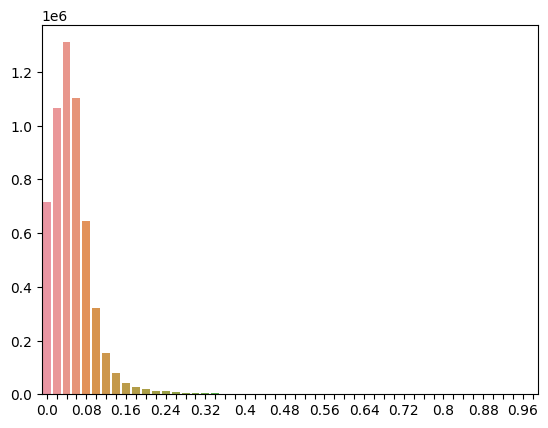

In [22]:


ax = sns.barplot(x=edges[:-1], y=hist)

_=ax.set_xticks(ticks = range(len(edges[:-1])), labels=[e if i%4 == 0 else "" for i, e in enumerate(edges[:-1])])

In [23]:
sequence_column_names = [f"seq_{i}" for i in range(sequences.shape[1])]

sequence_df = dd.from_dask_array(sequences, columns=sequence_column_names)

concatenated = dd.concat([dd.from_dask_array(sequence_lengths), dd.from_dask_array(collision_energy), dd.from_dask_array(comparisons), sequence_df], 1)
concatenated.columns = ["sequence_length", "collision_energy", "distance"] + sequence_column_names

concatenated

,sequence_length,collision_energy,distance,seq_0,seq_1,seq_2,seq_3,seq_4,seq_5,seq_6,seq_7,seq_8,seq_9,seq_10,seq_11,seq_12,seq_13,seq_14,seq_15,seq_16,seq_17,seq_18,seq_19,seq_20,seq_21,seq_22,seq_23,seq_24,seq_25,seq_26,seq_27,seq_28,seq_29
npartitions=6788,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,int64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
1000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6787000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6787932,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [24]:
concatenated.head()

,sequence_length,collision_energy,distance,seq_0,seq_1,seq_2,seq_3,seq_4,seq_5,seq_6,...,seq_20,seq_21,seq_22,seq_23,seq_24,seq_25,seq_26,seq_27,seq_28,seq_29
0,19,30.0,0.065209,19,4,18,20,13,18,12,...,0,0,0,0,0,0,0,0,0,0
1,12,20.0,-0.050648,10,13,12,5,10,4,10,...,0,0,0,0,0,0,0,0,0,0
2,13,35.0,0.055116,3,1,3,18,14,12,5,...,0,0,0,0,0,0,0,0,0,0
3,11,23.0,0.058689,3,10,10,14,10,6,6,...,0,0,0,0,0,0,0,0,0,0
4,12,25.0,0.085183,4,4,6,20,3,16,18,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Let's take a sample to quickly try out analyses
sample_size= 100000
sample = concatenated.head(sample_size)

In [26]:
collision_energy[:3].compute()

array([[30.],
       [20.],
       [35.]])

In [27]:
corr_columns = ["sequence_length", "collision_energy", "distance"]

with ProgressBar():
    sample = concatenated[corr_columns].head(100000)
    correlations = sample.corr()
    
correlations

[########################################] | 100% Completed | 308.07 ms


,sequence_length,collision_energy,distance
sequence_length,1.000000,0.017732,0.654690
collision_energy,0.017732,1.000000,0.046424
distance,0.654690,0.046424,1.000000


In [28]:
with ProgressBar():
    full_set_correlations = concatenated[corr_columns].corr().compute()

[########################################] | 100% Completed | 24m 15s


It seems that sequence length and distance have some correlation. I can imagine that longer sequences are more easy to predict because there is more info there? Or maybe there are unique sequences that are memorized. I wonder what the distribution is of sequence length.

<Axes: >

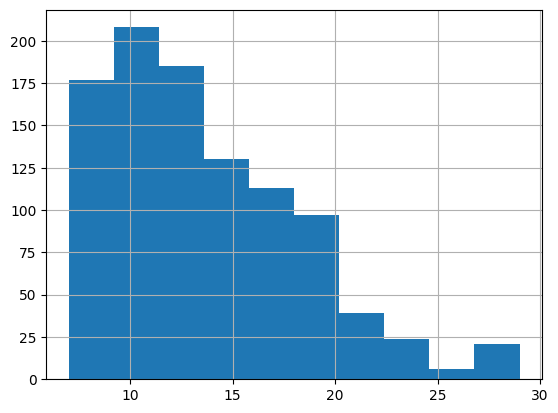

In [29]:
sample.sequence_length.hist()

In [30]:
# On the full set

freq, bins = da.histogram(concatenated["sequence_length"], bins=range(30))

with ProgressBar():
    freq = freq.compute()
    
bins = bins.compute()

[########################################] | 100% Completed | 22m 43s


Text(0.5, 1.0, 'Number of sequences per sequence length')

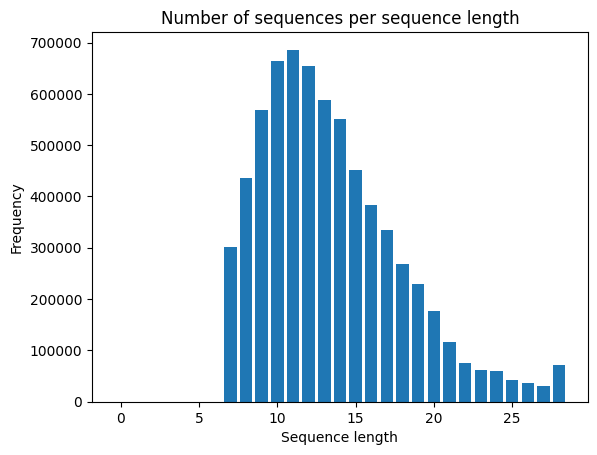

In [31]:
fig, ax = plt.subplots()

ax.bar(x=range(freq.shape[0]), height= freq)
ax.set_xlabel("Sequence length")
ax.set_ylabel("Frequency")

ax.set_title("Number of sequences per sequence length")

I wonder if there are any duplicates and whether it is possible that the model overfits on them.

In [32]:
counts = sequence_df.head(100000).groupby(sequence_df.columns.tolist(), as_index=False).size()

counts[counts["size"] > 1]

,seq_0,seq_1,seq_2,seq_3,seq_4,seq_5,seq_6,seq_7,seq_8,seq_9,...,seq_21,seq_22,seq_23,seq_24,seq_25,seq_26,seq_27,seq_28,seq_29,size
343,7,19,20,8,17,17,6,13,18,15,...,0,0,0,0,0,0,0,0,0,2
504,10,10,16,18,6,15,1,3,10,1,...,0,0,0,0,0,0,0,0,0,2


In [33]:
counts = sequence_df.groupby(sequence_df.columns.tolist()).size()

with ProgressBar():
    result = counts[counts > 1].compute()
    
result
    

[########################################] | 100% Completed | 335.33 s


seq_0  seq_1  seq_2  seq_3  seq_4  seq_5  seq_6  seq_7  seq_8  seq_9  seq_10  seq_11  seq_12  seq_13  seq_14  seq_15  seq_16  seq_17  seq_18  seq_19  seq_20  seq_21  seq_22  seq_23  seq_24  seq_25  seq_26  seq_27  seq_28  seq_29
1      1      1      1      17     6      17     8      5      17     5       15      0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0         35
                     9      6      10     10     3      6      8      4       10      6       9       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0         36
                     17     8      16     8      1      1      5      16      9       13      14      9       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0         34
              3      10     10     1      20     8      7      9  

Looks like there is one sequence that is in the dataset 2843 times! I wonder how that affects the training set. I also wonder if this sequence has consistent target values.

In [34]:
sorted_duplicates = result.sort_values(ascending=False)

pd.DataFrame(sorted_duplicates, columns=["number_of_duplicates"])


number_of_duplicates
seq_0 seq_1 seq_2 seq_3 seq_4 seq_5 seq_6 seq_7 seq_8 seq_9 seq_10 seq_11 seq_12 seq_13 seq_14 seq_15 seq_16 seq_17 seq_18 seq_19 seq_20 seq_21 seq_22 seq_23 seq_24 seq_25 seq_26 seq_27 seq_28 seq_29                      
7     19    20    8     17    17    6     13    18    15    4      9      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0                       2843
10    15    13    16    5     18    4     8     6     9     0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0                        108
      3     4     10    1     10    18    9     13    15    0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0                        108
      4     4     7     20    4     10    15    0     0     0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0                        108
      10    1     7     4     8     5     4     9     0     0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0                        108
...                                                                                                                                                                                                                       ...
5     14    15    1     17    16    8     9     0     0     0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0                          2
15    13    13    1     1     13    16    15    13    17    8      8      15     13     1      4      13     16     10     10     3      0      0      0      0      0      0      0      0      0                          2
19    18    3     3     17    7     1     10    6     18    5      16     16     13     8      17     1      15     3      1      10     6      8      9      0      0      0      0      0      0                          2
6     5     16    10    9     16    7     10    12    15    0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0                          2
11    13    6     5     20    16    18    21    17    3     4      4      8      9      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0                          2

[384923 rows x 1 columns]

## Distinguishing samples that perform well or badly



In [36]:
concatenated.head()

,sequence_length,collision_energy,distance,seq_0,seq_1,seq_2,seq_3,seq_4,seq_5,seq_6,...,seq_20,seq_21,seq_22,seq_23,seq_24,seq_25,seq_26,seq_27,seq_28,seq_29
0,19,30.0,0.065209,19,4,18,20,13,18,12,...,0,0,0,0,0,0,0,0,0,0
1,12,20.0,-0.050648,10,13,12,5,10,4,10,...,0,0,0,0,0,0,0,0,0,0
2,13,35.0,0.055116,3,1,3,18,14,12,5,...,0,0,0,0,0,0,0,0,0,0
3,11,23.0,0.058689,3,10,10,14,10,6,6,...,0,0,0,0,0,0,0,0,0,0
4,12,25.0,0.085183,4,4,6,20,3,16,18,...,0,0,0,0,0,0,0,0,0,0


In [37]:
with ProgressBar():
    best_performing = concatenated.sort_values("distance", ascending=False).head(1000)

best_performing

[########################################] | 100% Completed | 21m 27s
[########################################] | 100% Completed | 38m 15s


,sequence_length,collision_energy,distance,seq_0,seq_1,seq_2,seq_3,seq_4,seq_5,seq_6,...,seq_20,seq_21,seq_22,seq_23,seq_24,seq_25,seq_26,seq_27,seq_28,seq_29
4050898,29,23.0,0.953266,6,10,13,4,11,10,6,...,14,7,8,10,3,9,5,8,10,9
2649917,29,20.0,0.947326,4,4,10,4,4,10,16,...,17,18,13,21,8,13,10,6,10,9
1010122,29,23.0,0.942293,6,10,13,4,11,10,6,...,14,7,8,10,3,9,5,8,10,9
2013731,29,25.0,0.941248,1,10,10,16,14,10,13,...,10,10,1,18,6,4,1,10,8,9
4697025,29,28.0,0.941245,15,14,14,14,14,10,10,...,13,13,6,6,14,13,3,6,21,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6154770,29,23.0,0.877882,16,17,3,5,3,15,17,...,4,1,1,13,6,16,13,4,1,15
440801,29,25.0,0.877837,11,1,6,16,7,13,20,...,1,13,13,16,10,15,19,20,14,15
3520250,29,25.0,0.877830,12,10,20,10,14,20,12,...,18,16,18,14,20,10,12,10,14,15
4376226,29,25.0,0.877722,14,17,10,10,13,12,3,...,20,16,7,10,14,6,12,14,10,15


In [38]:
best_performing.iloc[0]

sequence_length     29.000000
collision_energy    23.000000
distance             0.953266
seq_0                6.000000
seq_1               10.000000
seq_2               13.000000
seq_3                4.000000
seq_4               11.000000
seq_5               10.000000
seq_6                6.000000
seq_7               18.000000
seq_8               13.000000
seq_9               21.000000
seq_10              14.000000
seq_11              14.000000
seq_12               8.000000
seq_13              13.000000
seq_14              14.000000
seq_15               2.000000
seq_16               1.000000
seq_17               6.000000
seq_18               2.000000
seq_19              12.000000
seq_20              14.000000
seq_21               7.000000
seq_22               8.000000
seq_23              10.000000
seq_24               3.000000
seq_25               9.000000
seq_26               5.000000
seq_27               8.000000
seq_28              10.000000
seq_29               9.000000
Name: 4050